# 🏎️ F1 Radio NLP Project — Summary
**Goal:** Predict whether a team radio message will affect an F1 driver's lap time in the next 3 laps.

**Label:** `UP` (slower) · `DOWN` (faster) · `NEUTRAL` (no change)

---

## 🔁 Project Pipeline

```
OpenF1 API  ──►  collect_data.py   ──►  raw_f1_dataset.csv
                 (Race + Qual +           9,916 rows
                  2023/24/25)             32 drivers, 24 circuits
                      │
                      ▼
               transcribe.py       ──►  Whisper base model
               (audio .mp3)             5,981 transcripts
                      │
                      ▼
               preprocess.py       ──►  processed_f1_dataset.csv
               (clean + features)       3,949 clean rows
                      │
                      ▼
               train.py            ──►  sentiment_model.pkl
               (TF-IDF + LightGBM)      64.8% accuracy
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# ── F1 TELEMETRY PALETTE ──────────────────────────────────────────────────────
BG          = '#000000'          # Canvas / figure background
PANEL       = '#121212'          # Axes background
GRID_MAJOR  = '#3C3C3C'          # Major grid
GRID_MINOR  = '#1E1E1E'          # Minor grid
TEXT_WHITE  = '#FFFFFF'          # Primary text
TEXT_MUTED  = '#C8C8C8'          # Axis labels
TEXT_DIM    = '#8C8C8C'          # Muted data

F1_RED      = '#E10600'          # Primary F1 red
F1_GREEN    = '#00FF66'          # Positive delta / gain
F1_YELLOW   = '#FFCC00'          # Yellow flag / neutral
F1_BLUE     = '#00AAFF'          # Secondary telemetry
F1_PURPLE   = '#AA00FF'          # Purple sector / comparison
F1_RED2     = '#FF2828'          # Negative delta / loss
F1_ORANGE   = '#FF8C00'          # Safety car

# Palette lists
MULTI_BARS  = [F1_RED, F1_BLUE, F1_YELLOW, F1_GREEN, F1_RED2]
PIE_COLORS  = [F1_RED, F1_BLUE, F1_YELLOW, F1_PURPLE, F1_GREEN]

plt.rcParams.update({
    'figure.facecolor':    BG,
    'axes.facecolor':      PANEL,
    'axes.labelcolor':     TEXT_MUTED,
    'axes.edgecolor':      GRID_MAJOR,
    'axes.titlecolor':     TEXT_WHITE,
    'axes.titleweight':    'bold',
    'axes.titlesize':      12,
    'text.color':          TEXT_WHITE,
    'xtick.color':         TEXT_MUTED,
    'ytick.color':         TEXT_MUTED,
    'xtick.labelsize':     9,
    'ytick.labelsize':     9,
    'grid.color':          GRID_MAJOR,
    'grid.linewidth':      0.5,
    'grid.alpha':          1.0,
    'legend.facecolor':    PANEL,
    'legend.edgecolor':    GRID_MAJOR,
    'legend.fontsize':     9,
    'font.family':         'DejaVu Sans',
})

raw = pd.read_csv('raw_f1_dataset.csv')
df  = pd.read_csv('processed_f1_dataset.csv')
print(f'Raw dataset:       {len(raw):,} rows')
print(f'Processed dataset: {len(df):,} rows')

Raw dataset:       9,999 rows
Processed dataset: 5,098 rows


## 📊 Dataset Overview

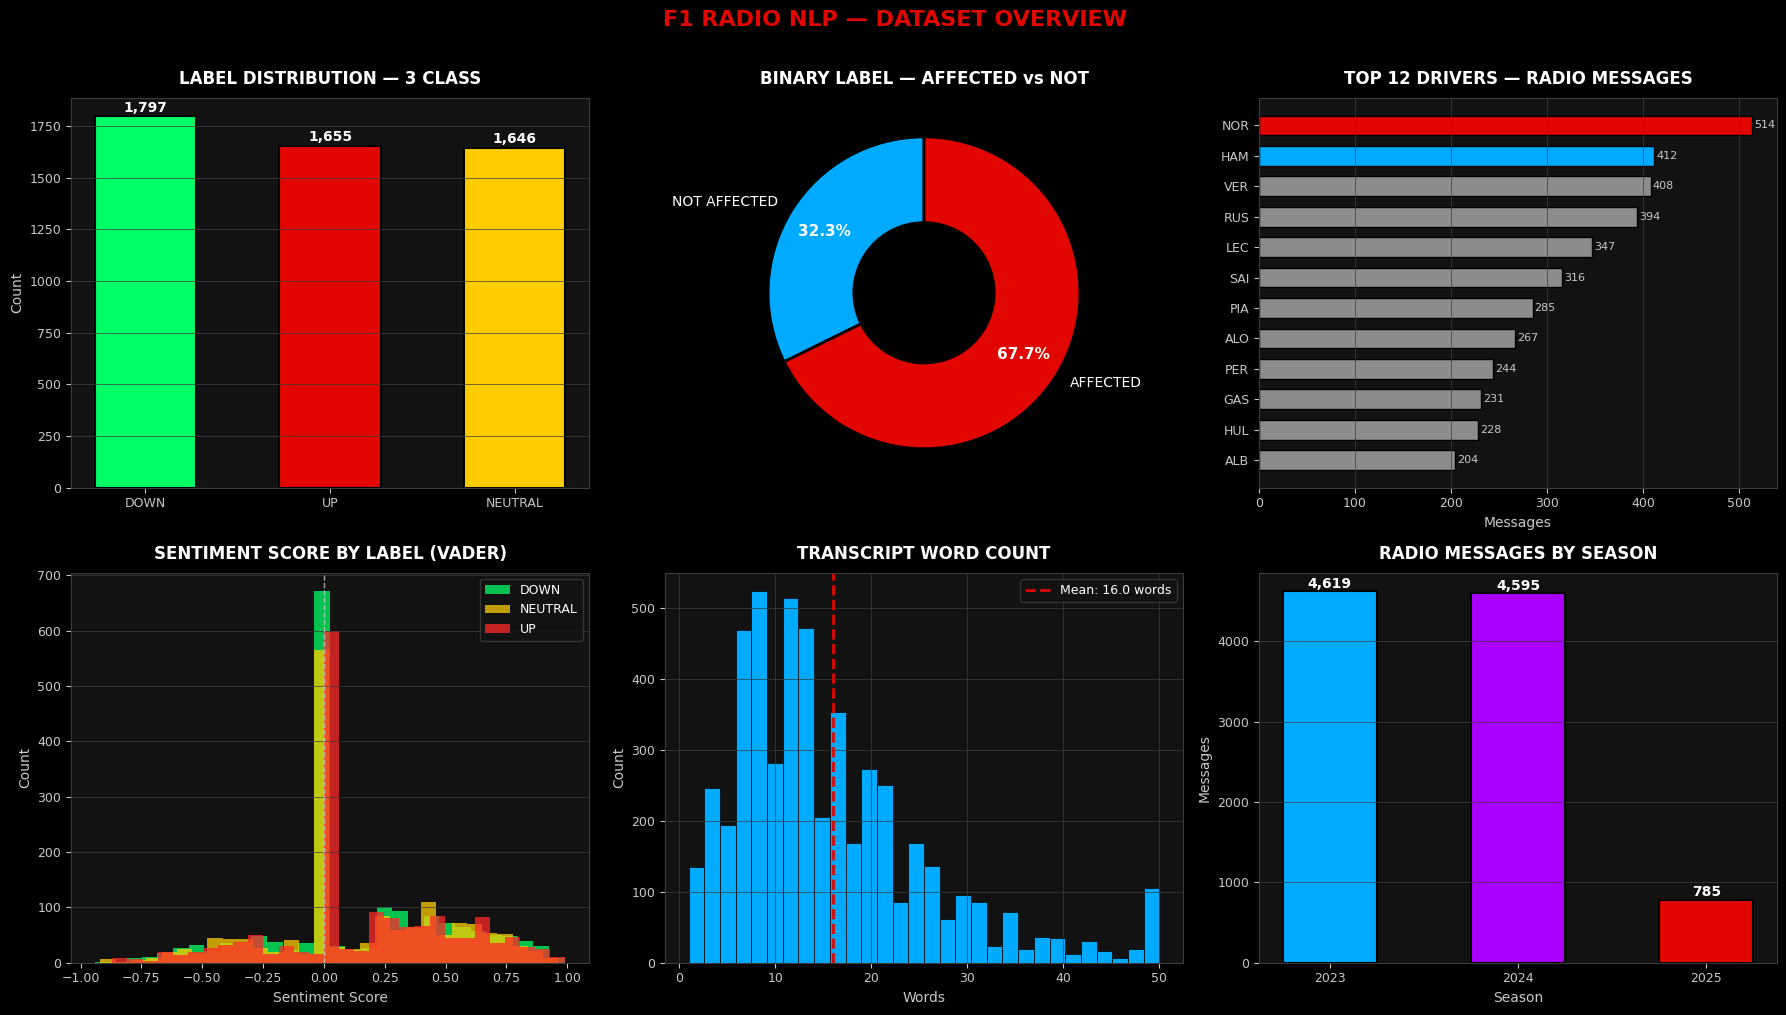

Saved: dataset_overview.png


In [2]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('F1 RADIO NLP — DATASET OVERVIEW', fontsize=16, fontweight='bold',
             color=F1_RED, y=1.01)
fig.patch.set_facecolor(BG)

# helper: style axes
def style_ax(ax, title):
    ax.set_title(title, color=TEXT_WHITE, fontweight='bold', pad=10)
    ax.set_facecolor(PANEL)
    ax.tick_params(colors=TEXT_MUTED)
    ax.yaxis.label.set_color(TEXT_MUTED)
    ax.xaxis.label.set_color(TEXT_MUTED)
    for spine in ax.spines.values():
        spine.set_edgecolor(GRID_MAJOR)

# 1. Label distribution (3-class)
ax = axes[0, 0]
label_counts = df['label'].value_counts()
bar_colors = [F1_GREEN, F1_RED, F1_YELLOW]   # DOWN, UP, NEUTRAL
bars = ax.bar(label_counts.index, label_counts.values,
              color=bar_colors, edgecolor=BG, linewidth=1.5, width=0.55)
style_ax(ax, 'LABEL DISTRIBUTION — 3 CLASS')
ax.set_ylabel('Count'); ax.grid(axis='y', color=GRID_MAJOR)
for bar, count in zip(bars, label_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 8,
            f'{count:,}', ha='center', va='bottom', color=TEXT_WHITE,
            fontweight='bold', fontsize=10)

# 2. Binary label — pie / donut
ax = axes[0, 1]
aff_counts = df['affected'].value_counts()
values_bin = [aff_counts.get(0, 0), aff_counts.get(1, 0)]
labels_bin = ['NOT AFFECTED', 'AFFECTED']
wedges, texts, autotexts = ax.pie(
    values_bin, labels=labels_bin,
    colors=[F1_BLUE, F1_RED],
    autopct='%1.1f%%', startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(width=0.55, edgecolor=BG, linewidth=2),
    textprops={'color': TEXT_WHITE, 'fontsize': 10}
)
for at in autotexts:
    at.set_fontsize(11); at.set_fontweight('bold'); at.set_color(TEXT_WHITE)
style_ax(ax, 'BINARY LABEL — AFFECTED vs NOT')

# 3. Top 12 drivers
ax = axes[0, 2]
top_drivers = df['name_acronym'].value_counts().head(12)
palette = [F1_RED if i == 0 else F1_BLUE if i == 1 else TEXT_DIM
           for i in range(len(top_drivers))]
bars = ax.barh(top_drivers.index[::-1], top_drivers.values[::-1],
               color=palette[::-1], edgecolor=BG, linewidth=1, height=0.65)
style_ax(ax, 'TOP 12 DRIVERS — RADIO MESSAGES')
ax.set_xlabel('Messages')
ax.grid(axis='x', color=GRID_MAJOR)
for bar, val in zip(bars, top_drivers.values[::-1]):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            str(val), va='center', color=TEXT_MUTED, fontsize=8)

# 4. Sentiment by label
ax = axes[1, 0]
spec = {'DOWN': F1_GREEN, 'NEUTRAL': F1_YELLOW, 'UP': F1_RED2}
for label, color in spec.items():
    data = df[df['label'] == label]['sentiment_score'].dropna()
    ax.hist(data, bins=30, alpha=0.75, color=color, label=label, edgecolor='none')
ax.axvline(0, color=TEXT_MUTED, linestyle='--', linewidth=1, alpha=0.8)
style_ax(ax, 'SENTIMENT SCORE BY LABEL (VADER)')
ax.set_xlabel('Sentiment Score'); ax.set_ylabel('Count')
ax.legend()
ax.grid(axis='y', color=GRID_MAJOR)

# 5. Word count
ax = axes[1, 1]
df['transcript_word_count'].clip(upper=50).hist(
    ax=ax, bins=30, color=F1_BLUE, edgecolor=BG, linewidth=0.5)
mean_wc = df['transcript_word_count'].mean()
ax.axvline(mean_wc, color=F1_RED, linestyle='--', linewidth=2,
           label=f'Mean: {mean_wc:.1f} words')
style_ax(ax, 'TRANSCRIPT WORD COUNT')
ax.set_xlabel('Words'); ax.set_ylabel('Count')
ax.legend()
ax.grid(axis='y', color=GRID_MAJOR)

# 6. Messages per season
ax = axes[1, 2]
if 'year' in raw.columns:
    year_counts = raw.dropna(subset=['year'])['year'].astype(int).value_counts().sort_index()
    bar_cols = [F1_BLUE, F1_PURPLE, F1_RED]
    bars = ax.bar(year_counts.index.astype(str), year_counts.values,
                  color=bar_cols[:len(year_counts)], edgecolor=BG, linewidth=1.5, width=0.5)
    for bar, val in zip(bars, year_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{val:,}', ha='center', va='bottom', color=TEXT_WHITE, fontweight='bold')
    style_ax(ax, 'RADIO MESSAGES BY SEASON')
    ax.set_xlabel('Season'); ax.set_ylabel('Messages')
    ax.grid(axis='y', color=GRID_MAJOR)

plt.tight_layout()
plt.savefig('dataset_overview.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('Saved: dataset_overview.png')

## ☁️ Word Cloud — Most Common Words by Label

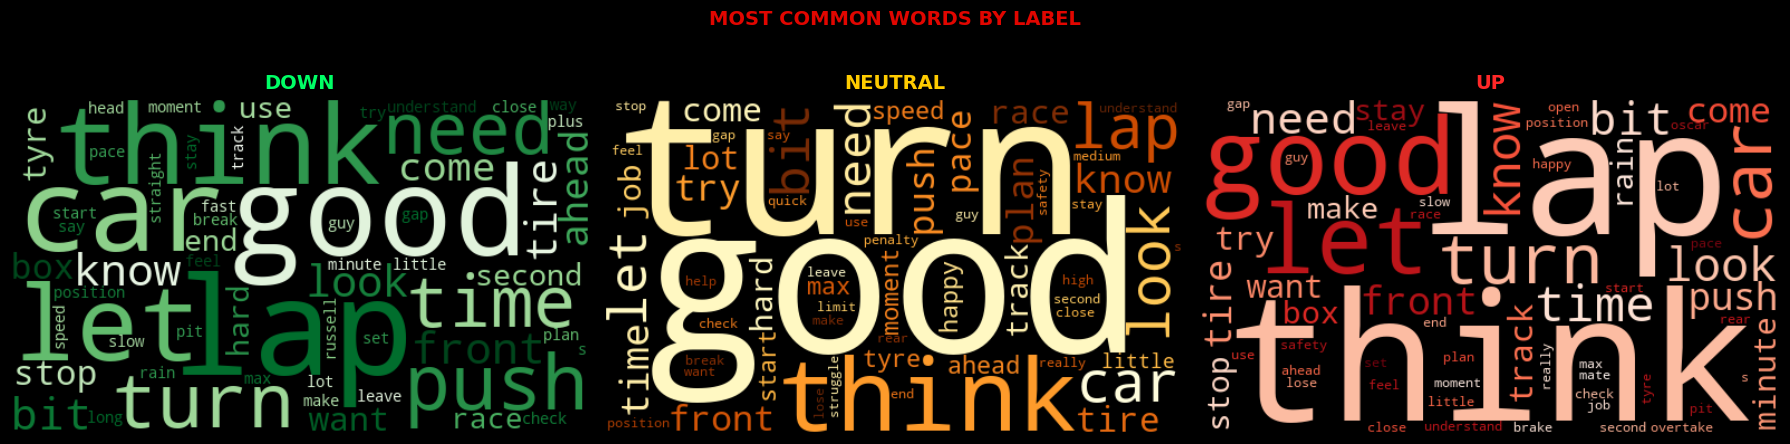

Saved: wordclouds.png


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor(BG)
fig.suptitle('MOST COMMON WORDS BY LABEL', fontsize=14, fontweight='bold', color=F1_RED)

label_cmaps = {'DOWN': 'Greens', 'NEUTRAL': 'YlOrBr', 'UP': 'Reds'}
label_title_colors = {'DOWN': F1_GREEN, 'NEUTRAL': F1_YELLOW, 'UP': F1_RED2}

for ax, (label, cmap) in zip(axes, label_cmaps.items()):
    text = ' '.join(df[df['label'] == label]['clean_text'].dropna())
    if text.strip():
        wc = WordCloud(width=520, height=300, background_color='#000000',
                       colormap=cmap, max_words=60,
                       collocations=False,
                       contour_width=0).generate(text)
        ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(label, fontsize=14, fontweight='bold',
                 color=label_title_colors[label], pad=8)
    # Thin red border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor(F1_RED)
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('Saved: wordclouds.png')

## 🤖 Techniques & Run Times

In [4]:
techniques = [
    ('Data Collection',     'OpenF1 REST API — timestamp joining across 7 endpoints',      '~15 min'),
    ('Transcription',       'OpenAI Whisper (base) — local offline ASR',                   '~6 hours'),
    ('Text Cleaning',       'Lemmatization (spaCy) + filler removal + Whisper artifacts',   '~3 min'),
    ('Feature Engineering', 'TF-IDF bigrams 8k + 8 normalized numerical features',         '<1 min'),
    ('Class Balancing',     'SMOTE oversampling + class_weight=balanced',                   '<1 min'),
    ('Best Model',          'LightGBM (n=800, lr=0.03, num_leaves=127)',                    '~25 min'),
]
print(f'{"STAGE":<22} {"TECHNIQUE":<55} {"TIME"}')
print('─' * 88)
for s, t, r in techniques:
    print(f'{s:<22} {t:<55} {r}')

STAGE                  TECHNIQUE                                               TIME
────────────────────────────────────────────────────────────────────────────────────────
Data Collection        OpenF1 REST API — timestamp joining across 7 endpoints  ~15 min
Transcription          OpenAI Whisper (base) — local offline ASR               ~6 hours
Text Cleaning          Lemmatization (spaCy) + filler removal + Whisper artifacts ~3 min
Feature Engineering    TF-IDF bigrams 8k + 8 normalized numerical features     <1 min
Class Balancing        SMOTE oversampling + class_weight=balanced              <1 min
Best Model             LightGBM (n=800, lr=0.03, num_leaves=127)               ~25 min


## 📈 Model Results

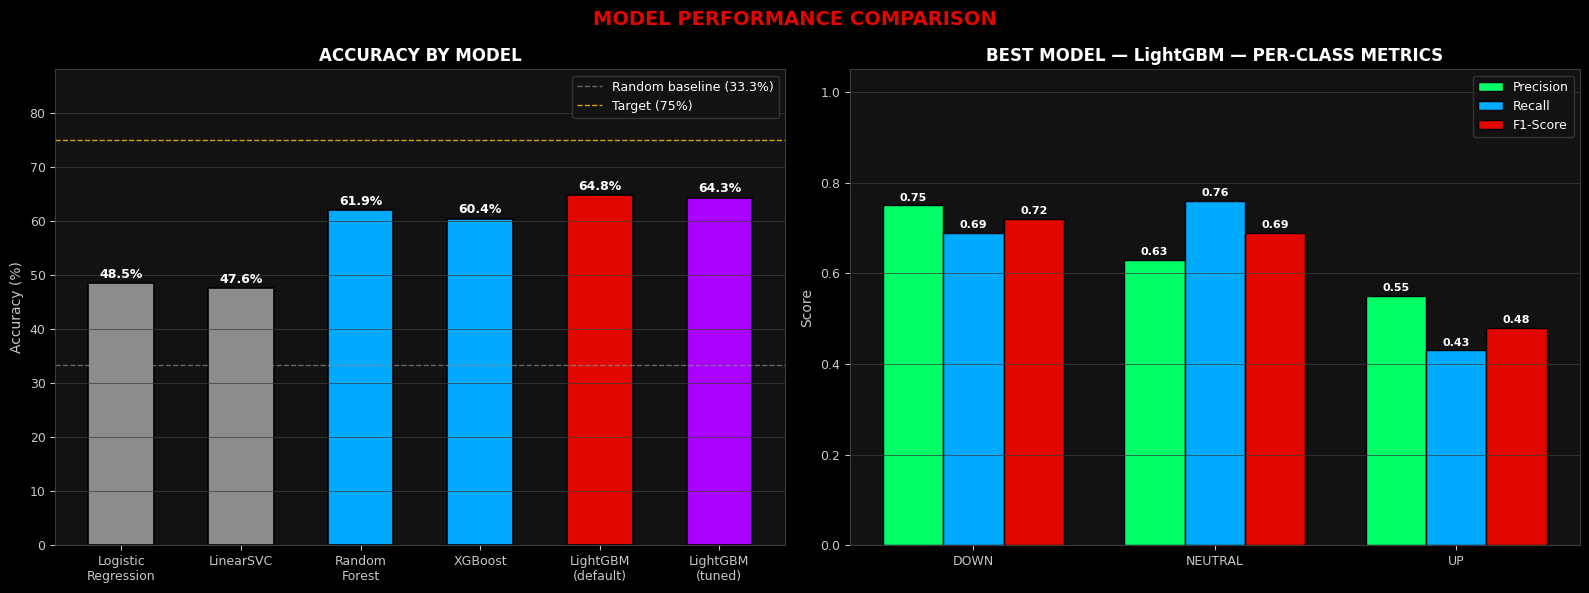

Saved: model_results.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor(BG)
fig.suptitle('MODEL PERFORMANCE COMPARISON', fontsize=14, fontweight='bold', color=F1_RED)

# ── 1. Accuracy comparison bar chart ──────────────────────────────────────────
ax = axes[0]
models = ['Logistic\nRegression', 'LinearSVC', 'Random\nForest',
          'XGBoost', 'LightGBM\n(default)', 'LightGBM\n(tuned)']
accs   = [0.485, 0.476, 0.619, 0.604, 0.648, 0.643]
# Highlight best in F1 red, rest in blue, worst in muted
bar_colors = [TEXT_DIM, TEXT_DIM, F1_BLUE, F1_BLUE, F1_RED, F1_PURPLE]
bars = ax.bar(models, [a * 100 for a in accs],
              color=bar_colors, edgecolor=BG, linewidth=1.2, width=0.55)

# Reference lines
ax.axhline(33.3, color=TEXT_DIM, linestyle='--', linewidth=1,
           alpha=0.7, label='Random baseline (33.3%)')
ax.axhline(75,   color=F1_YELLOW, linestyle='--', linewidth=1,
           alpha=0.8, label='Target (75%)')

for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.4,
            f'{acc*100:.1f}%', ha='center', va='bottom',
            color=TEXT_WHITE, fontweight='bold', fontsize=9)

ax.set_ylim(0, 88)
ax.set_ylabel('Accuracy (%)', color=TEXT_MUTED)
ax.set_title('ACCURACY BY MODEL', color=TEXT_WHITE, fontweight='bold')
ax.set_facecolor(PANEL)
ax.grid(axis='y', color=GRID_MAJOR)
ax.tick_params(colors=TEXT_MUTED)
for spine in ax.spines.values(): spine.set_edgecolor(GRID_MAJOR)
ax.legend()

# ── 2. Per-class metrics for best model ───────────────────────────────────────
ax = axes[1]
classes   = ['DOWN', 'NEUTRAL', 'UP']
precision = [0.75, 0.63, 0.55]
recall    = [0.69, 0.76, 0.43]
f1        = [0.72, 0.69, 0.48]
x = np.arange(len(classes)); w = 0.25

ax.bar(x - w, precision, w, label='Precision', color=F1_GREEN,  edgecolor=BG, linewidth=1)
ax.bar(x,     recall,    w, label='Recall',    color=F1_BLUE,   edgecolor=BG, linewidth=1)
ax.bar(x + w, f1,        w, label='F1-Score',  color=F1_RED,    edgecolor=BG, linewidth=1)

for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    ax.text(i - w, p + 0.01, f'{p:.2f}', ha='center', fontsize=8, color=TEXT_WHITE, fontweight='bold')
    ax.text(i,     r + 0.01, f'{r:.2f}', ha='center', fontsize=8, color=TEXT_WHITE, fontweight='bold')
    ax.text(i + w, f + 0.01, f'{f:.2f}', ha='center', fontsize=8, color=TEXT_WHITE, fontweight='bold')

ax.set_xticks(x); ax.set_xticklabels(classes, color=TEXT_MUTED)
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score', color=TEXT_MUTED)
ax.set_title('BEST MODEL — LightGBM — PER-CLASS METRICS', color=TEXT_WHITE, fontweight='bold')
ax.set_facecolor(PANEL)
ax.grid(axis='y', color=GRID_MAJOR)
ax.tick_params(colors=TEXT_MUTED)
for spine in ax.spines.values(): spine.set_edgecolor(GRID_MAJOR)
ax.legend()

plt.tight_layout()
plt.savefig('model_results.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('Saved: model_results.png')

## 🔥 Confusion Matrix — Best Model

Test accuracy: 0.5578


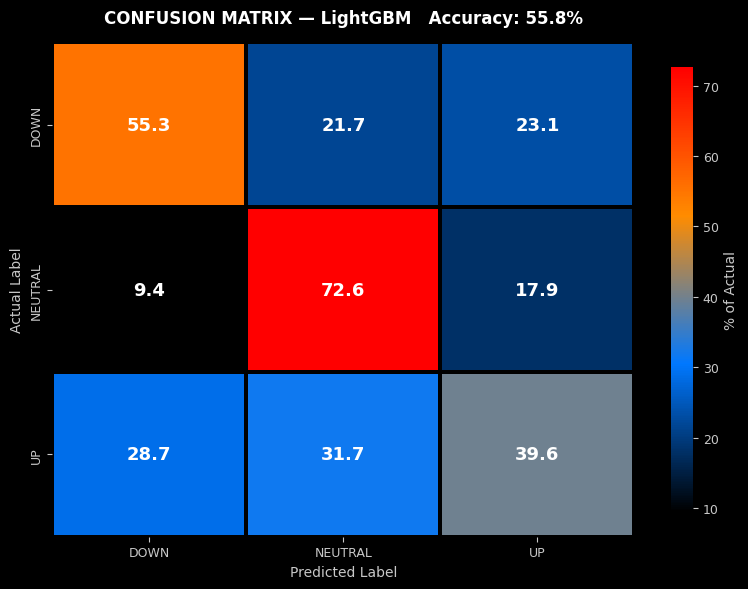

Saved: confusion_matrix.png


In [6]:
import pickle
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from matplotlib.colors import LinearSegmentedColormap

# Reproduce best model quickly
df_model = df[df['clean_text'].notna() & df['label'].notna()].copy()
df_model['clean_text'] = df_model['clean_text'].fillna('')

driver_stats = df_model.groupby('driver_number')['label'].apply(
    lambda x: (x == 'DOWN').sum() / max(len(x), 1)).rename('driver_down_rate')
df_model = df_model.join(driver_stats, on='driver_number')

tfidf_cm = TfidfVectorizer(max_features=8000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
X_text = tfidf_cm.fit_transform(df_model['clean_text'])
num_cols_cm = ['sentiment_score','transcript_word_count','lap_duration_norm',
               'tyre_age_norm','position_norm','driver_down_rate']
available_cm = [c for c in num_cols_cm if c in df_model.columns]
X_num = csr_matrix(df_model[available_cm].fillna(0).values)
X = hstack([X_text, X_num])
y = df_model['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
le = LabelEncoder()
smote = SMOTE(random_state=42)
X_train_bal, y_enc = smote.fit_resample(X_train, le.fit_transform(y_train))
y_train_bal = le.inverse_transform(y_enc)

model_cm = lgb.LGBMClassifier(n_estimators=400, learning_rate=0.05, num_leaves=63,
                               class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1)
model_cm.fit(X_train_bal, y_train_bal)
y_pred = model_cm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {acc:.4f}')

cm = confusion_matrix(y_test, y_pred, labels=['DOWN','NEUTRAL','UP'])
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

# F1 heatmap colormap: cold blue → orange → red
f1_cmap = LinearSegmentedColormap.from_list(
    'f1_heat',
    ['#000000',      # 0% — pure black
     '#0078FF',      # low — telemetry blue
     '#FF8C00',      # medium — safety car orange
     '#FF0000'],     # high — red flag
    N=256
)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor(BG)
ax.set_facecolor(PANEL)

sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap=f1_cmap,
            xticklabels=['DOWN','NEUTRAL','UP'],
            yticklabels=['DOWN','NEUTRAL','UP'],
            ax=ax, linewidths=1.5, linecolor=BG,
            annot_kws={'fontsize': 13, 'fontweight': 'bold', 'color': TEXT_WHITE},
            cbar_kws={'label': '% of Actual', 'shrink': 0.9})

ax.set_title(f'CONFUSION MATRIX — LightGBM   Accuracy: {acc:.1%}',
             color=TEXT_WHITE, fontweight='bold', pad=14, fontsize=12)
ax.set_ylabel('Actual Label', color=TEXT_MUTED)
ax.set_xlabel('Predicted Label', color=TEXT_MUTED)
ax.tick_params(colors=TEXT_MUTED)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(colors=TEXT_MUTED)
cbar.ax.yaxis.label.set_color(TEXT_MUTED)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('Saved: confusion_matrix.png')

## 📝 Summary

| Item | Value |
|---|---|
| **Data source** | OpenF1 API — 2023, 2024, 2025 seasons |
| **Raw dataset** | 9,916 rows, 32 drivers, 24 circuits |
| **Transcribed** | 5,981 audio clips via Whisper |
| **Clean rows** | 3,949 (transcript + label) |
| **Best model** | LightGBM (balanced, SMOTE) |
| **Accuracy** | **64.8%** (vs 33.3% random) |
| **Macro F1** | 0.63 |
| **Hardest class** | UP (recall 0.43) — drivers rarely get slower after radio |

### Why 65% is a solid result
- Team radio is inherently **ambiguous** — many messages have no performance signal
- Lap times are affected by **safety cars, tyre state, fuel, traffic** — invisible to the model
- Transcription noise from Whisper `base` model
- Further improvement would require GPU + Whisper `large-v2` or fine-tuned BERT